In [2]:
%cd ..

/Volumes/ext_thumb/repos/PWC_Net_tf


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import tensorflow as tf
from dataset import get_kitti_stereo_dataset
from model import build_model
import matplotlib.pyplot as plt
import cv2 as cv
import matplotlib
import numpy as np
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [5]:
ckpt_path = 'trained_ckpt/ckpt'
kitti_path = 'data/kitti_2012_stereo_flow.tfrecords'
test_ds, im_shape = get_kitti_stereo_dataset(
    kitti_path, 1)
model = build_model(im_shape)
model.load_weights(ckpt_path)

image shape:  (376, 1241, 3)
6 level values reduced by 0.015625 scale
5 level values reduced by 0.03125 scale
4 level values reduced by 0.0625 scale
3 level values reduced by 0.125 scale
2 level values reduced by 0.25 scale

Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.sequential.Sequential object at 0x155df10d0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x1536c1a90>).


In [6]:
batch = list(test_ds.skip(1).take(1).as_numpy_iterator())
feats, disp_gt = batch[0]
outs = model.predict(batch)
disparity = outs[0]
corr_vols = outs[1]
# disp = disparity[0].squeeze()
# disp_gt = disp_gt[0].squeeze()
l_img = feats['left_view'][0]
r_img = feats['right_view'][0]

In [11]:
corr_vols = corr_vols+[None, None]
corr_vols.reverse()

In [13]:
cvol=corr_vols[-2]

In [56]:
disp = np.argmax(cvol, axis=-1)
disp=disp.squeeze()

In [69]:
# plt.imshow(disp)
disp

array([[7, 6, 5, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 4, 3, 2, 1],
       [6, 7, 6, 5, 4, 3, 2, 4, 4, 3, 2, 0, 0, 0, 6, 5, 4, 3, 2, 1],
       [6, 6, 6, 5, 4, 3, 4, 4, 3, 3, 2, 1, 1, 3, 6, 5, 4, 3, 2, 1],
       [5, 4, 3, 3, 4, 4, 4, 4, 4, 3, 2, 2, 2, 3, 6, 5, 4, 3, 2, 1],
       [5, 4, 3, 2, 4, 4, 3, 2, 1, 0, 2, 2, 2, 2, 6, 5, 4, 3, 2, 1],
       [5, 4, 3, 2, 1, 3, 3, 2, 6, 5, 4, 3, 2, 7, 6, 5, 4, 3, 2, 1]])

In [41]:
def low_res(big_im, out_shape):
    _, h, w, _ = out_shape
    small_im = cv.resize(big_im, (w,h), cv.INTER_AREA)
    return small_im

def rgb_to_ft(im):
    return im/ np.expand_dims(np.linalg.norm(im, axis=-1), axis=-1)

def toy_corr_vol(l_im, r_im, max_disp=2):
    l_im = low_res(l_im, disparity[6].shape)/255.
    r_im = low_res(r_im, disparity[6].shape)/255.
    l_ft, r_ft = rgb_to_ft(l_im), rgb_to_ft(r_im)
    r_pad = np.pad(r_im, ((0,0), (max_disp,0), (0,0)))
    corr_vol=[]
    for shift in range(max_disp+1):
        r_shift = r_pad[:,shift:shift+l_im.shape[1],:]
        corr_slice = np.mean(np.multiply(l_im, r_shift), axis=-1)
        corr_vol.append(corr_slice)
    corr_vol = np.stack(corr_vol, axis=-1)
    return l_im, r_im, corr_vol

l_im, r_im, corr_vol = toy_corr_vol(l_img, r_img)
toy_disp = 2-np.argmax(corr_vol, axis=-1)

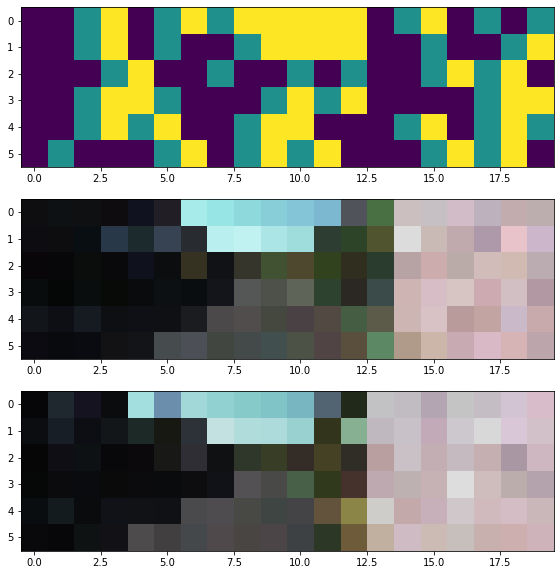

In [42]:
_, ax = plt.subplots(nrows=3, ncols=1)
ax[0].imshow(toy_disp)
ax[1].imshow(l_im)
ax[2].imshow(r_im)

In [39]:
# toy_disp
lf, rf = rgb_to_ft(l_im[0,-6]), rgb_to_ft(r_im[0,-7])
print(np.vdot(lf, rf))
toy_disp[0,-6]

lf, rf = rgb_to_ft(l_im[0,-6]), rgb_to_ft(r_im[0,-6+2])
print(np.vdot(lf, rf))
rgb_to_ft(l_im[0,-6])

0.9996128565257301
0.9996476311515459


array([0.59977852, 0.56432363, 0.56727821])

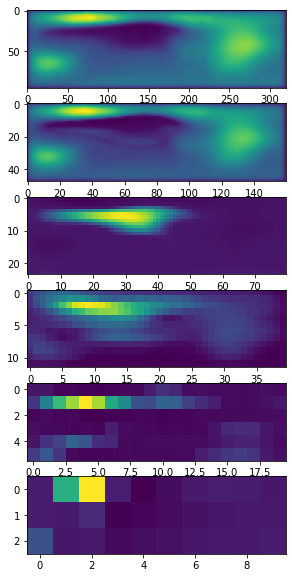

In [52]:
_, ax = plt.subplots(nrows=6, ncols=1)
for lvl in range(2, 8):
    ax[lvl-2].imshow(disparity[0][lvl].squeeze())

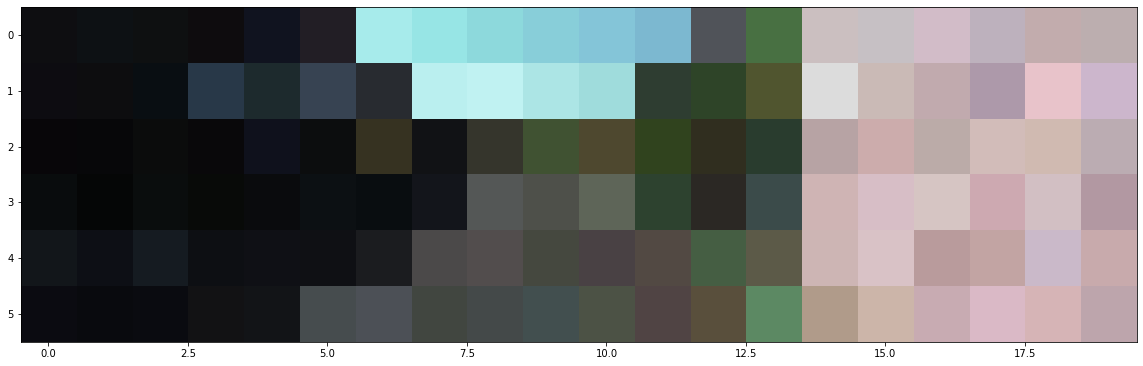

In [82]:
plt.imshow(low_res(l_img))

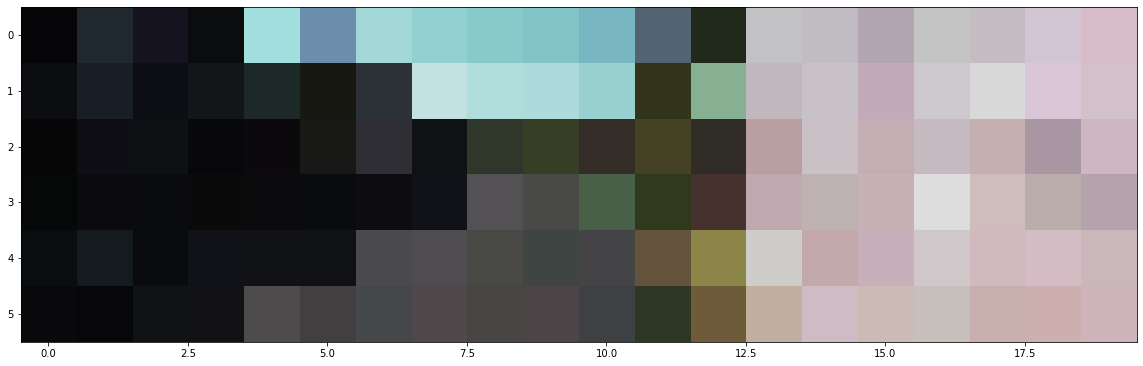

In [83]:
plt.imshow(low_res(r_img))

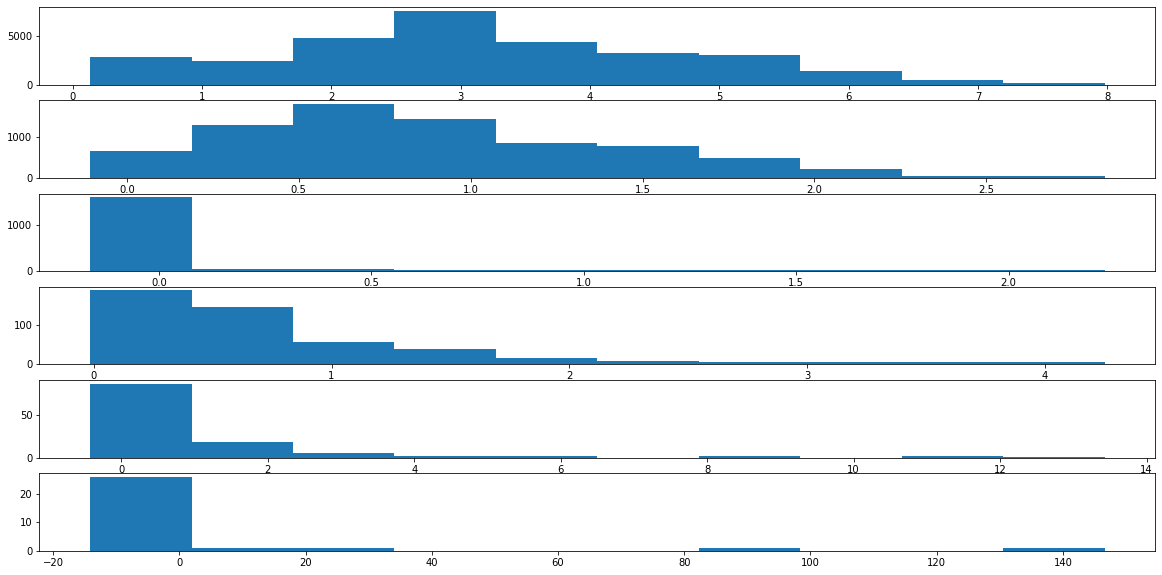

In [54]:
_, ax = plt.subplots(nrows=6, ncols=1)
for lvl in range(2, 8):
    ax[lvl-2].hist(disparity[0][lvl].squeeze().flatten())

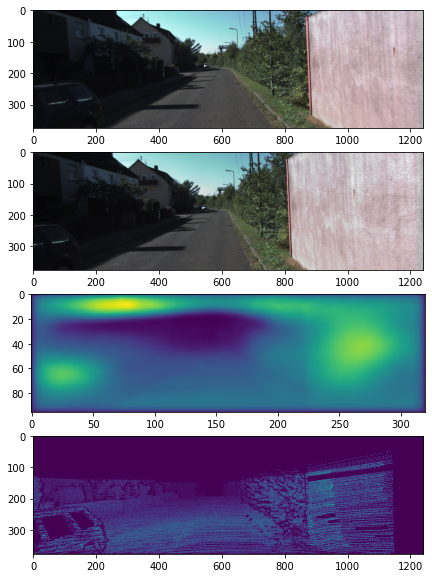

In [55]:
_, ax = plt.subplots(nrows=4, ncols=1)
ax[0].imshow(l_img)
ax[1].imshow(r_img)
ax[2].imshow(disp)
ax[3].imshow(disp_gt)

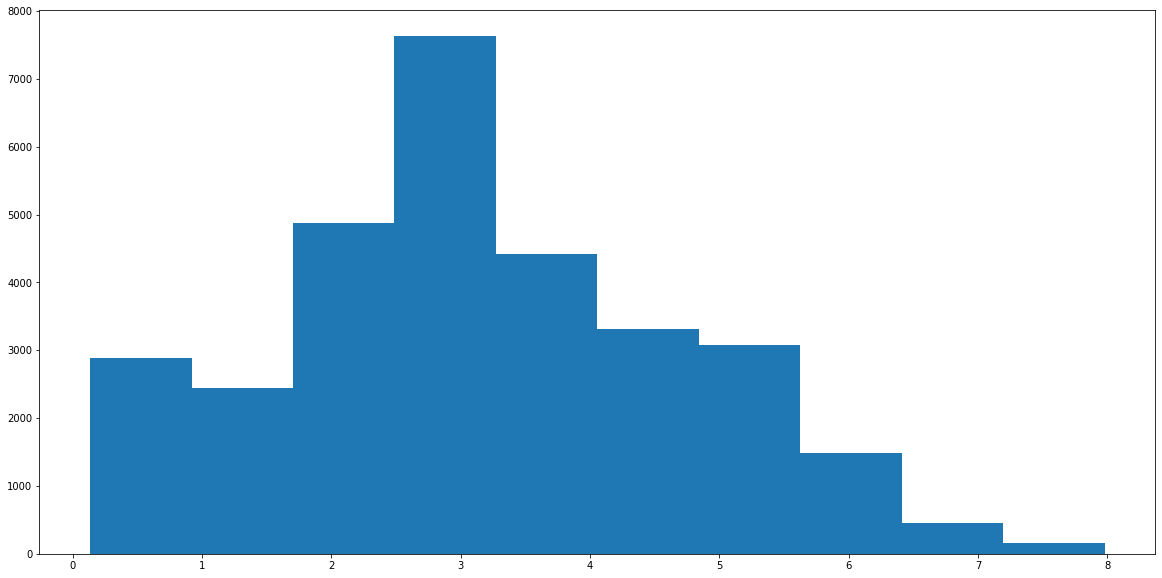

In [56]:
_ = plt.hist(disp.flatten())